In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ot
import ot.plot
import pandas as pd
import umap
from scipy.spatial import procrustes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from umap.parametric_umap import ParametricUMAP

2024-10-07 15:40:12.696901: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 15:40:12.699681: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 15:40:12.708889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 15:40:12.724495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 15:40:12.729024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 15:40:12.740369: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
data = np.load("data/ihb.npy")

In [ ]:
# Check the shape of the data
print("Original shape:", data.shape)  # Should be (320, 10, 246)

# Create a mask to identify samples with NaNs in the last dimension
mask_nan = np.isnan(data).any(axis=(1, 2))

# Split the data into two arrays
data_no_nans = data[~mask_nan]  # Samples without NaNs
data_with_nans = data[mask_nan][:, :, :200]  # Samples with NaNs

Original shape: (320, 10, 246)


In [ ]:
mask_nan

array([False,  True, False, False,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False, False, False,  True, False, False,  True,  True,
       False,  True, False,  True, False, False,  True, False, False,
        True, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True,  True, False,  True, False,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True,  True, False,
       False, False,

In [ ]:
# Output shapes of the split arrays
print("Shape of data without NaNs:", data_no_nans.shape)
print("Shape of data with NaNs:", data_with_nans.shape)

Shape of data without NaNs: (160, 10, 246)
Shape of data with NaNs: (160, 10, 200)


In [ ]:
def apply_cos_sin_scaling(data):
    # Assuming the time steps are along axis 1 (i.e., second dimension in (160, 10, 246))
    time_steps = np.arange(data.shape[1])  # create a time step array, shape (10,)

    # Normalize the time steps to [0, 2π]
    normalized_time_steps = (
        2
        * np.pi
        * (time_steps - np.min(time_steps))
        / (np.max(time_steps) - np.min(time_steps))
    )

    # Apply sine and cosine transformations
    sin_transformed = np.sin(normalized_time_steps).reshape(
        1, data.shape[1], 1
    )  # Shape (1, 10, 1)
    cos_transformed = np.cos(normalized_time_steps).reshape(
        1, data.shape[1], 1
    )  # Shape (1, 10, 1)

    # Broadcast sin and cos over the data dimensions (160, 10, 246)
    sin_transformed = np.tile(
        sin_transformed, (data.shape[0], 1, data.shape[2])
    )  # Shape (160, 10, 246)
    cos_transformed = np.tile(
        cos_transformed, (data.shape[0], 1, data.shape[2])
    )  # Shape (160, 10, 246)

    # Scale data using sin and cos transformations
    scaled_data = data * sin_transformed + data * cos_transformed

    # The shape of scaled_data will be (160, 10, 246)
    return scaled_data


data_no_nans = apply_cos_sin_scaling(data_no_nans)
data_with_nans = apply_cos_sin_scaling(data_with_nans)

In [ ]:
def get_corr_matrics(some_data):

    correlation_matrices = []

    # Loop over each scan
    for i in range(some_data.shape[0]):
        # Get the time series for all brain regions in this scan (shape: 10, 246)
        time_series = some_data[i, :, :]

        # Compute the Pearson correlation matrix (shape: 246, 246)
        corr_matrix = np.corrcoef(time_series, rowvar=False)

        # Append the correlation matrix to the list
        correlation_matrices.append(corr_matrix)

    # Convert the list to a numpy array (shape: 320, 246, 246)
    correlation_matrices = np.array(correlation_matrices)

    # Output the shape to confirm the result
    print("Shape of correlation matrices:", correlation_matrices.shape)

    return correlation_matrices

In [ ]:
def fisher_transform(corr):
    # Clip values to avoid issues with arccosh for values very close to -1 or 1
    corr = np.clip(corr, -0.999999, 0.999999)
    return 0.5 * np.log((1 + corr) / (1 - corr))


# Assuming your correlation matrix is named `correlation_matrices`
# with shape (320, 246, 246)
# def apply_transforms(correlation_matrices):
#     # Step 1: Fisher's r-to-z transformation
#     def fisher_transform(corr):
#         # Clip values to avoid issues with arccosh for values very close to -1 or 1
#         corr = np.clip(corr, -0.999999, 0.999999)
#         return 0.5 * np.log((1 + corr) / (1 - corr))

#     # Apply Fisher transformation to each correlation matrix
#     z_matrices = fisher_transform(correlation_matrices)

#     # Step 2: Pseudo z-scoring
#     # Here we will standardize each matrix (mean = 0, std = 1)
#     def pseudo_z_score(z_matrices):
#         # Calculate mean and std along the last two dimensions (246, 246)
#         mean = np.mean(z_matrices, axis=(1, 2), keepdims=True)
#         std = np.std(z_matrices, axis=(1, 2), keepdims=True)

#         # Standardize
#         return (z_matrices - mean) / std

#     # Apply pseudo z-scoring
#     return pseudo_z_score(z_matrices)

In [ ]:
no_nans_corr = fisher_transform(get_corr_matrics(data_no_nans))
with_nans_corr = fisher_transform(get_corr_matrics(data_with_nans))

Shape of correlation matrices: (160, 246, 246)
Shape of correlation matrices: (160, 200, 200)


In [ ]:
# Assuming `correlation_matrices` is of shape (320, 246, 246)


# Function to extract the upper triangle of the correlation matrix, excluding the diagonal
def flatten_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]  # k=1 excludes the diagonal


# Flatten each 246x246 correlation matrix into a 1D vector (upper triangle only)
flattened_matrices_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in with_nans_corr]
)

flattened_matrices_no_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in no_nans_corr]
)

In [ ]:
print("Shape of flattened matrices with NaNs:", flattened_matrices_nans.shape)
print("Shape of flattened matrices without NaNs:", flattened_matrices_no_nans.shape)

Shape of flattened matrices with NaNs: (160, 19900)
Shape of flattened matrices without NaNs: (160, 30135)


In [ ]:
# Set UMAP parameters
n_neighbors = 8  # You can adjust this value
min_dist = 0.1  # You can adjust this value
n_components = 2  # You can adjust the number of components

# Apply UMAP to the data with NaN values
umap_model_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_nans = umap_model_nans.fit_transform(flattened_matrices_nans)

# Apply UMAP to the data without NaN values
umap_model_no_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_no_nans = umap_model_no_nans.fit_transform(flattened_matrices_no_nans)

# Concatenate the UMAP results
flattened_matrices = np.concatenate((umap_result_nans, umap_result_no_nans), axis=0)

print("Shape of flattened matrices:", flattened_matrices.shape)

I0000 00:00:1728305495.209949   37858 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 15:51:35.211957: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.3810
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3438
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3424
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3421
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3421
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3402
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3388
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3414
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3390
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3392


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.4015
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3556
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3509
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3490
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3475
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3466
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3486
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3470
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3459
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.3448
Shape of flattened matrices: (320, 2)


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


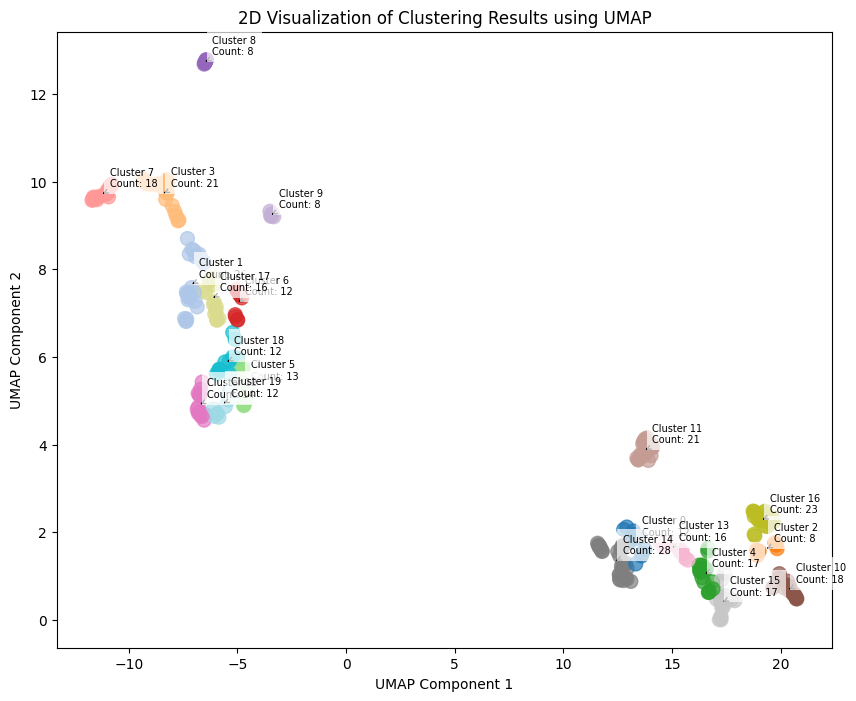

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# Step 1: Dimensionality reduction using UMAP to 2 dimensions
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=16,
    min_dist=0.1,
    random_state=42,
    spread=1,  # metric="correlation"
)
reduced_data = umap_reducer.fit_transform(flattened_matrices)

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts, strict=False))

# Calculate the centroids of each cluster
centroids = np.array(
    [reduced_data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
)

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Annotate the centroids with the number of objects in each cluster
for i in range(num_clusters):
    plt.annotate(
        f"Cluster {i}\nCount: {cluster_counts[i]}",  # Text to display
        xy=centroids[i],  # Coordinates of the centroid
        xytext=(5, 5),  # Offset for the text
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        arrowprops={"arrowstyle": "->", "lw": 1, "color": "black"},
    )

# Show color bar
# Not applicable here since we are using custom colors for clusters
plt.show()

In [ ]:
cost_matrix = ot.dist(umap_result_nans, umap_result_no_nans)

# Uniform weights for both datasets (can also be custom)
a = (
    np.ones((umap_result_nans.shape[0],)) / umap_result_nans.shape[0]
)  # Distribution weight for data1
b = (
    np.ones((umap_result_nans.shape[0],)) / umap_result_nans.shape[0]
)  # Distribution weight for data2

# Regularization parameter for Sinkhorn (controls the entropy)
reg = 0.5

# Solve the optimal transport problem using Sinkhorn algorithm
transport_plan = ot.sinkhorn(a, b, cost_matrix, reg)

# Compute the aligned dataset by applying the transport plan to data2
aligned_data1 = transport_plan.dot(umap_result_no_nans)

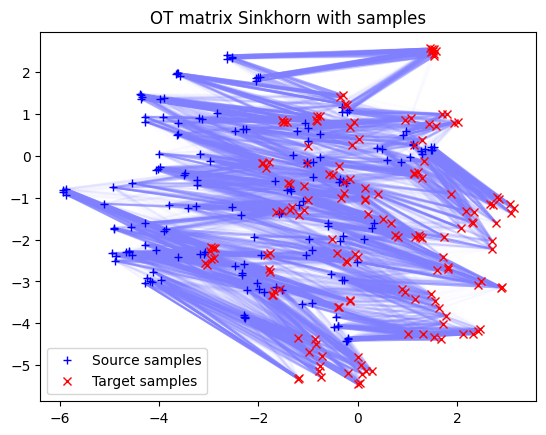

In [ ]:
plt.figure(12)
ot.plot.plot2D_samples_mat(
    umap_result_nans, umap_result_no_nans, transport_plan, color=[0.5, 0.5, 1]
)
plt.plot(umap_result_nans[:, 0], umap_result_nans[:, 1], "+b", label="Source samples")
plt.plot(
    umap_result_no_nans[:, 0], umap_result_no_nans[:, 1], "xr", label="Target samples"
)
plt.legend(loc=0)
plt.title("OT matrix Sinkhorn with samples")

plt.show()

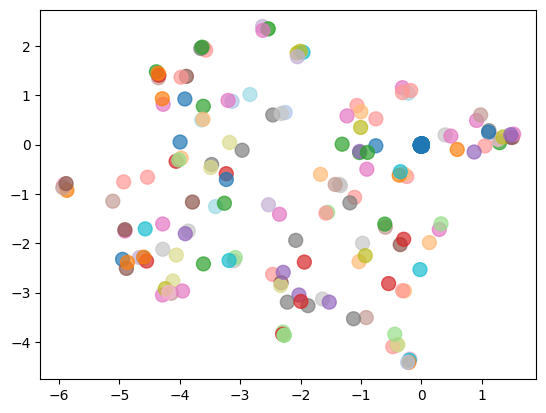

In [ ]:
test = np.concatenate((aligned_data1, umap_result_nans), axis=0)
plt.scatter(
    test[:, 0],
    test[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

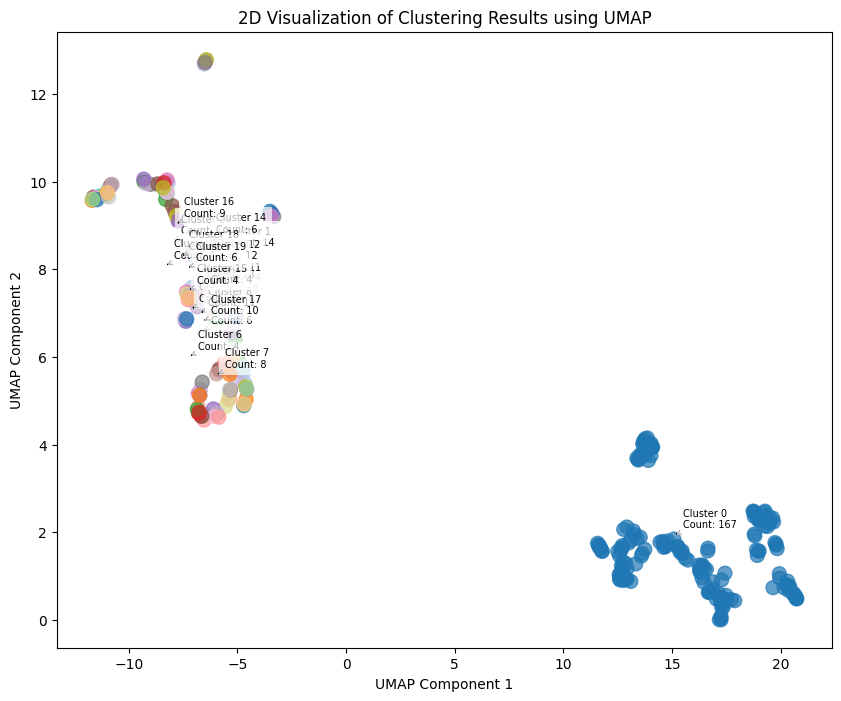

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# # Step 1: Dimensionality reduction using UMAP to 2 dimensions
# umap_reducer = umap.UMAP(
#     n_components=2,
#     n_neighbors=16,
#     min_dist=0.1,
#     random_state=42,
#     spread=1,  # metric="correlation"
# )
# reduced_data = umap_reducer.fit_transform(flattened_matrices)


# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(test)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts, strict=False))

# Calculate the centroids of each cluster
centroids = np.array(
    [reduced_data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
)

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Annotate the centroids with the number of objects in each cluster
for i in range(num_clusters):
    plt.annotate(
        f"Cluster {i}\nCount: {cluster_counts[i]}",  # Text to display
        xy=centroids[i],  # Coordinates of the centroid
        xytext=(5, 5),  # Offset for the text
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        arrowprops={"arrowstyle": "->", "lw": 1, "color": "black"},
    )

# Show color bar
# Not applicable here since we are using custom colors for clusters
plt.show()

In [ ]:
mtx1, mtx2, disparity = procrustes(umap_result_nans, umap_result_no_nans)

/tmp/ipykernel_37858/1183198378.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


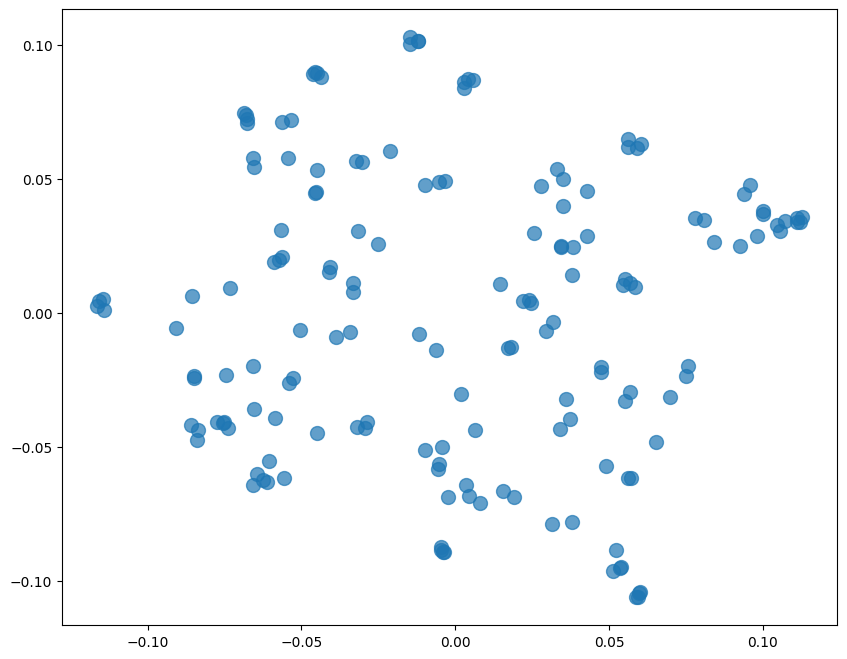

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    mtx1[:, 0],
    mtx1[:, 1],
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

/tmp/ipykernel_37858/309694243.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


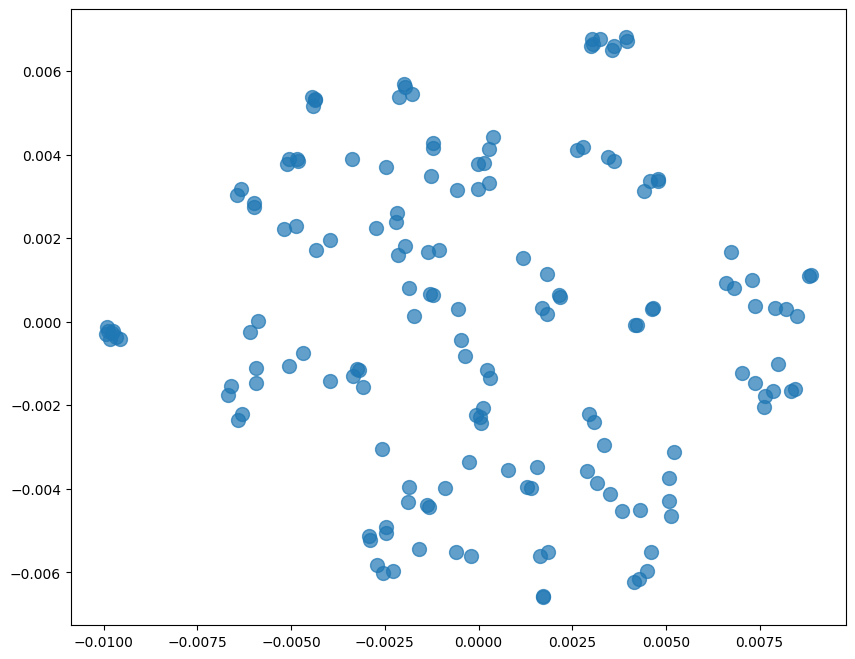

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    mtx2[:, 0],
    mtx2[:, 1],
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

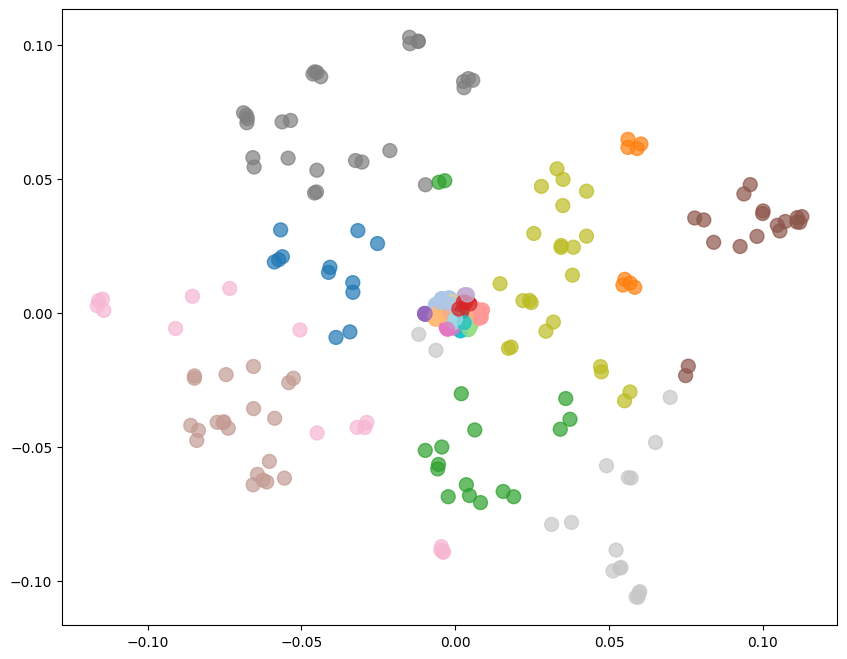

In [ ]:
temp = np.concatenate((mtx1, mtx2), axis=0)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    temp[:, 0],
    temp[:, 1],
    cmap="tab20",  # Change to a more distinct colormap
    c=cluster_labels,
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

In [ ]:
# Assume 'data' is your original data array
# cluster_labels is the prediction for the concatenated data

# Step 1: Initialize an array for the original shape of data with NaN
original_labels = np.full(data.shape[0], np.nan)

# Assuming data is 3D, adjust accordingly

# Step 2: Assign the cluster labels back
# For samples without NaNs
original_labels[~mask_nan] = cluster_labels[data_no_nans.shape[0] :]

# For samples with NaNs
original_labels[mask_nan] = cluster_labels[: data_with_nans.shape[0]]

submission_df = pd.DataFrame({"prediction": original_labels})
submission_df["prediction"] = submission_df["prediction"].astype(int)
# Save the submission to a CSV file
submission_df.to_csv("submissions/" + "neuroli.csv", index=False)